**Importing the main libraries**

In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

### Preprocessing pipeline

We will take every image from each folder and do the following steps to it:
* Convert to grayscale, normalize it (max abs scaling) and the resize it
* One hot encode the labels (since they're 26+)

In [2]:
def load_data(folder_path, img_size=64, num_samples_per_class=500):
    data = []
    labels = []
    folders = os.listdir(folder_path)
    
    for label in tqdm(folders, desc="Loading data", unit="class"):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            image_names = os.listdir(label_path)
            sampled_images = random.sample(image_names, min(num_samples_per_class, len(image_names)))
            
            for img_name in sampled_images:
                img_path = os.path.join(label_path, img_name)
                # Load image in grayscale mode
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Resize the image to the target size
                    img_resized = cv2.resize(img, (img_size, img_size))
                    data.append(img_resized)
                    # Convert label to numeric: 'A'=0, ..., 'Z'=25, 'Nothing'=26, 'Space'=27
                    if label == "Nothing":
                        labels.append(26)
                    elif label == "Space":
                        labels.append(27)
                    else:
                        labels.append(ord(label) - ord('A'))

    data = np.array(data)
    labels = np.array(labels)
    
    # Max abs scaling
    data = data.astype('float32') / 255.0
    
    # Reshape data
    data = data.reshape(-1, img_size, img_size, 1)  # (num_samples, height, width, channels)
    
    return data, labels

In [3]:
train_data, train_labels = load_data('/kaggle/input/american-sign-language/ASL_Dataset/Train')
test_data, test_labels = load_data('/kaggle/input/american-sign-language/ASL_Dataset/Test')

train_labels = to_categorical(train_labels, num_classes=28)
test_labels = to_categorical(test_labels, num_classes=28)

Loading data: 100%|██████████| 28/28 [00:01<00:00, 22.33class/s]


### Looking at our preprocessed samples

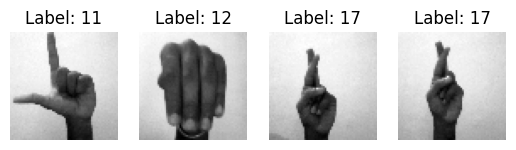

In [4]:
def display_random_samples(data, labels, num_samples=3):
    indices = np.random.choice(len(data), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(data[idx].reshape(64, 64), cmap='gray')
        plt.title(f"Label: {np.argmax(labels[idx])}") 
        plt.axis('off')
    plt.show()


display_random_samples(train_data, train_labels, 4)

### Model building (CNN based architecture for classificaiton)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
def create_simple_cnn(input_shape=(64, 64, 1), num_classes=28):
    model = Sequential()
    model.add(Input(input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  
    
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def create_improved_cnn(input_shape=(64, 64, 1), num_classes=28):
    model = Sequential()
    
    model.add(Input(input_shape))
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
  
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  
    
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [7]:
model = create_improved_cnn()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,268 (1.63 MB)

 Trainable params: 425,308 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Name of the file to save the model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # We want to minimize the validation loss
    verbose=1  # Print messages when saving
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    mode='min',  # Stop when the quantity monitored has stopped decreasing
    verbose=1  # Print messages when stopping
)

In [9]:
history = model.fit(train_data, train_labels, 
                    validation_data=(test_data, test_labels), 
                    epochs=20,callbacks=[checkpoint, early_stopping] , 
                    batch_size=64)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.6019 - loss: 1.4288
Epoch 1: val_loss improved from inf to 11.41449, saving model to best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 115s 505ms/step - accuracy: 0.6029 - loss: 1.4253 - val_accuracy: 0.0357 - val_loss: 11.4145
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9953 - loss: 0.0403
Epoch 2: val_loss improved from 11.41449 to 10.98925, saving model to best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 110s 501ms/step - accuracy: 0.9953 - loss: 0.0403 - val_accuracy: 0.0357 - val_loss: 10.9892
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9985 - loss: 0.0137
Epoch 3: val_loss improved from 10.98925 to 0.15343, saving model to best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 111s 506ms/step - accuracy: 0.9985 - loss: 0.0137 - val_accuracy: 0.9286 - val_loss: 0.1534
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9988 - loss: 0.0094
Epoch 4: val_loss did not im

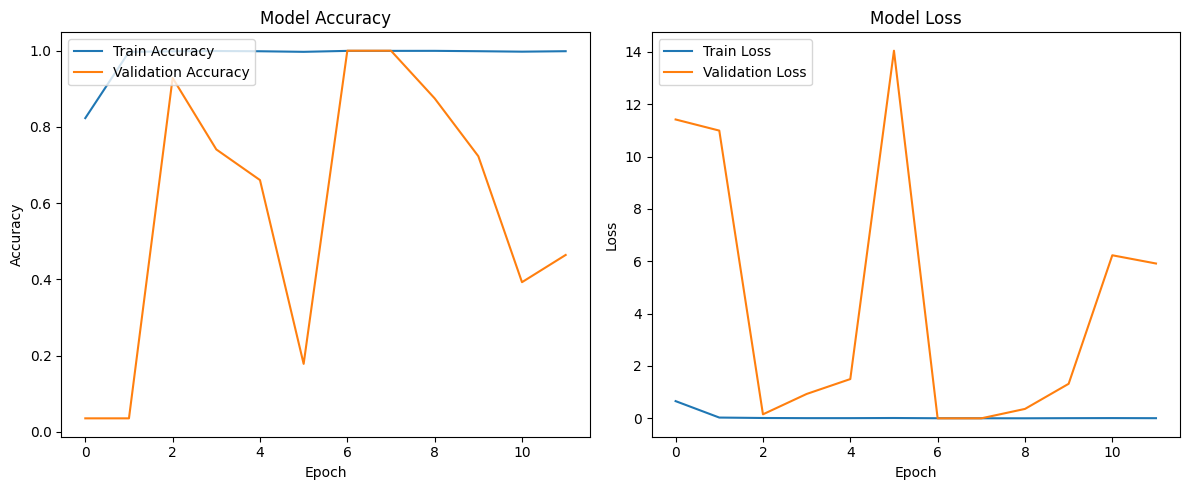

In [10]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Loading our saved model

In [11]:
model = load_model('best_model.keras')

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


In [14]:
print(predicted_classes)
print(len(set(predicted_classes)))

[13 13 13 13 17 17 17 17 27 27 27 27  1  1  1  1  8  8  8  8  5  5  5  5
  7  7  7  7  4  4  4  4 20 20 20 20 12 12 12 12 23 23 23 23 10 10 10 10
 16 16 16 16 24 24 24 24 18 18 18 18  6  6  6  6  0  0  0  0 14 14 14 14
 19 19 19 19 21 21 21 21 25 25 25 25  2  2  2  2 15 15 15 15 11 11 11 11
 22 22 22 22  3  3  3  3 26 26 26 26  9  9  9  9]
28


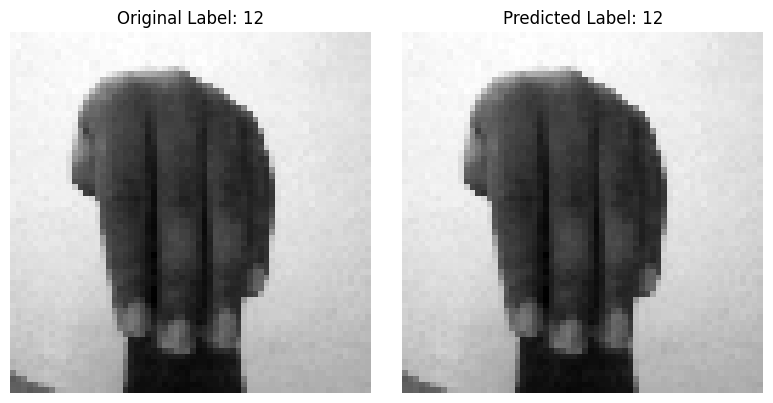

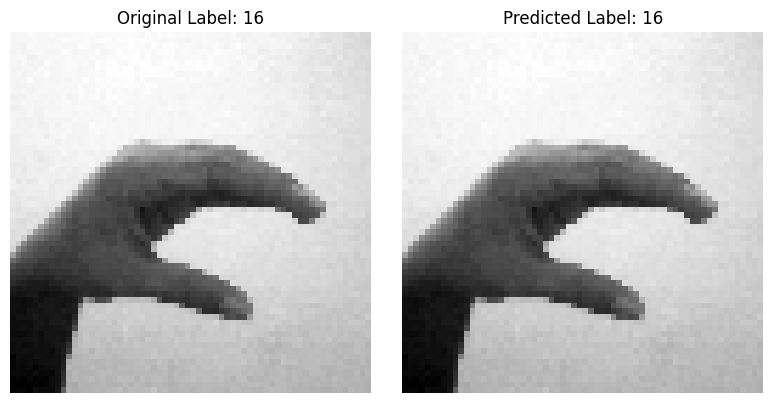

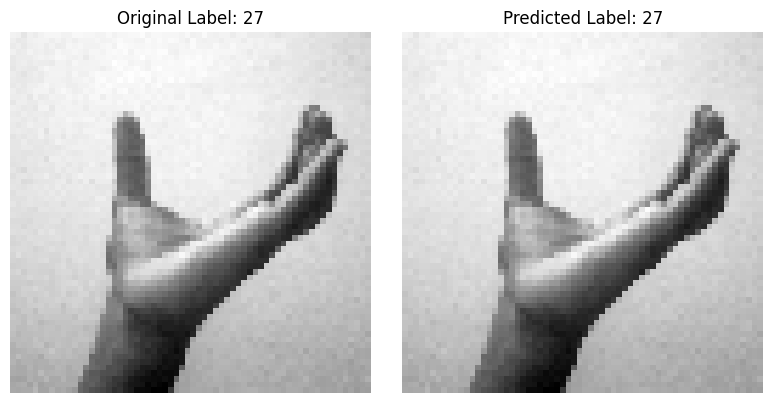

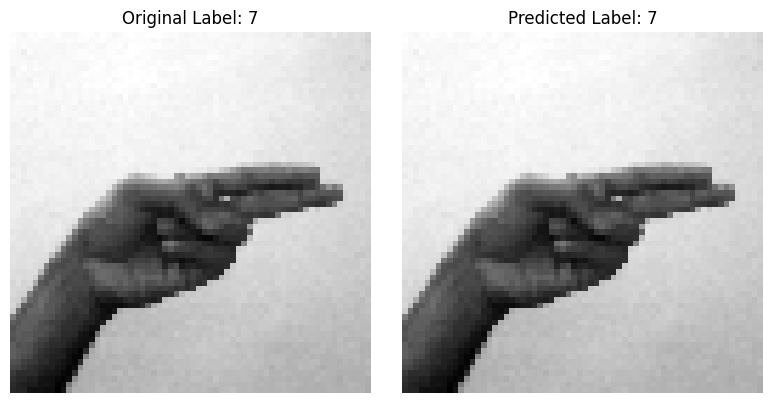

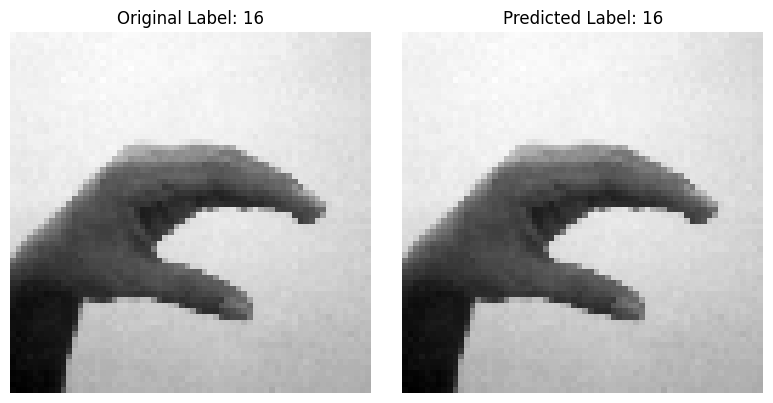

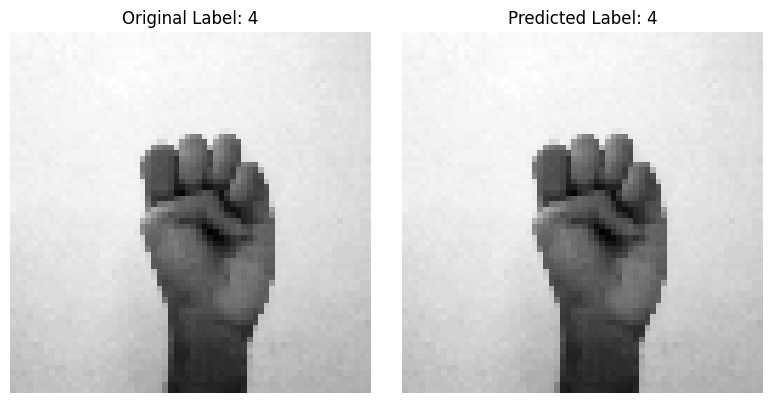

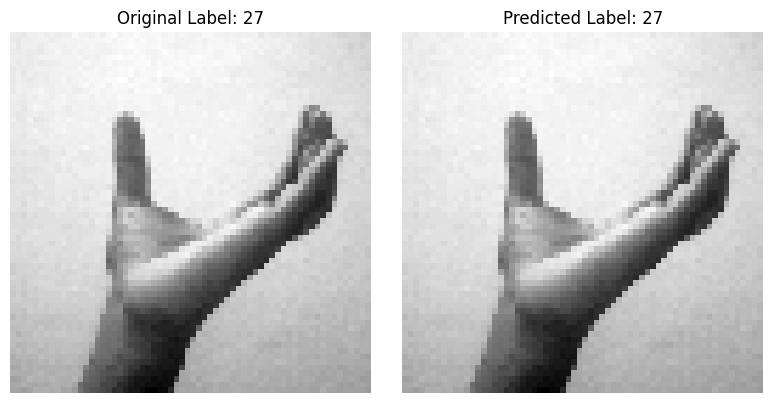

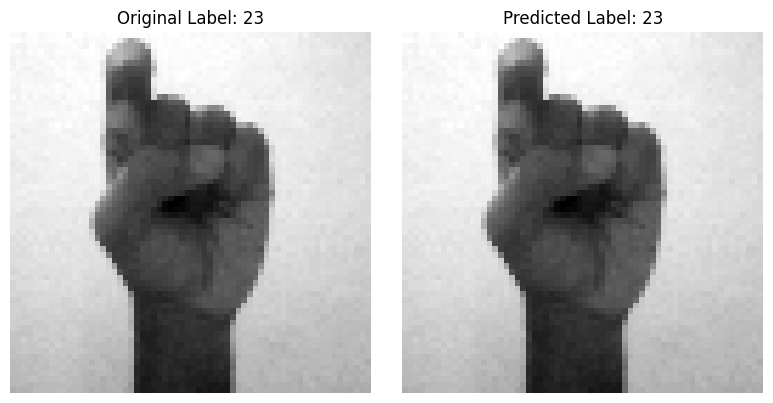

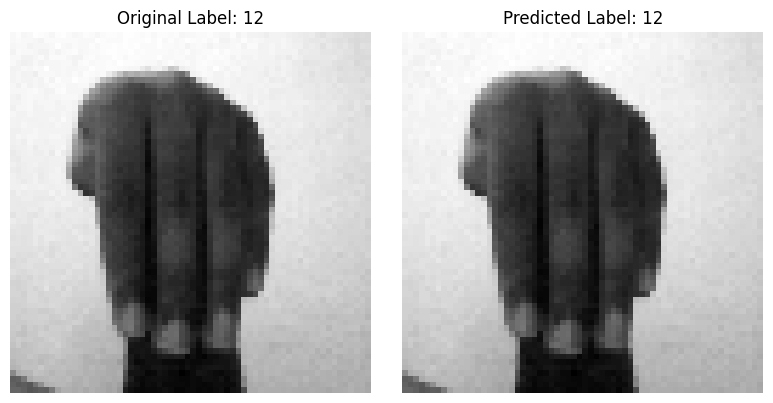

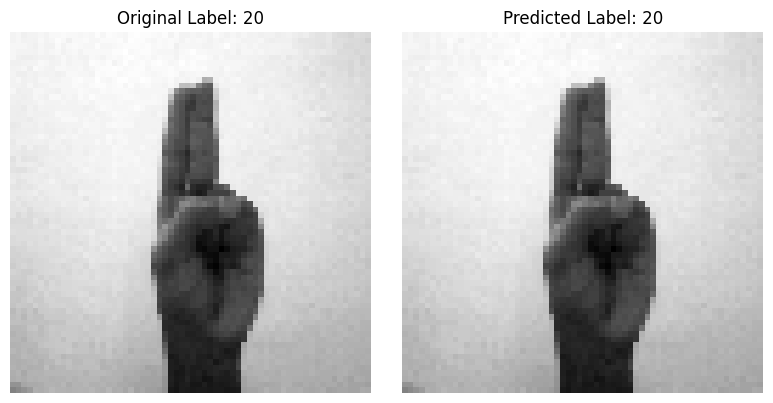

In [15]:
def display_image_with_labels(index):

    original_label = np.argmax(test_labels[index])
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(test_data[index], cmap='gray')
    axes[0].set_title(f"Original Label: {original_label}")
    axes[0].axis('off') 
    
  
    axes[1].imshow(test_data[index].reshape(64, 64), cmap='gray')
    axes[1].set_title(f"Predicted Label: {predicted_classes[index]}")
    axes[1].axis('off')  # Hide the axes
    
    plt.tight_layout()
    plt.show()

for i in np.random.randint(1, 50, 10):
    display_image_with_labels(i)

#  **MODEL 2**

In [16]:
model2 =  create_simple_cnn()
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,188 (6.21 MB)

 Trainable params: 1,628,188 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
checkpoint = ModelCheckpoint(
    'simple-cnn.keras',  # Name of the file to save the model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # We want to minimize the validation loss
    verbose=1  # Print messages when saving
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    mode='min',  # Stop when the quantity monitored has stopped decreasing
    verbose=1  # Print messages when stopping
)

In [19]:
history = model2.fit(train_data, train_labels, 
                    validation_data=(test_data, test_labels), 
                    epochs=20,callbacks=[checkpoint, early_stopping] , 
                    batch_size=64)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9637 - loss: 0.0967
Epoch 1: val_loss did not improve from 0.00177
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 162ms/step - accuracy: 0.9637 - loss: 0.0966 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9721 - loss: 0.0811
Epoch 2: val_loss improved from 0.00177 to 0.00020, saving model to simple-cnn.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 163ms/step - accuracy: 0.9721 - loss: 0.0811 - val_accuracy: 1.0000 - val_loss: 2.0003e-04
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9715 - loss: 0.0789
Epoch 3: val_loss did not improve from 0.00020
219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 164ms/step - accuracy: 0.9715 - loss: 0.0789 - val_accuracy: 1.0000 - val_loss: 2.9627e-04
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9734 - loss: 0.0712
Epoch 4: val_loss did not improve from 0.00020
219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 165ms/step - accuracy

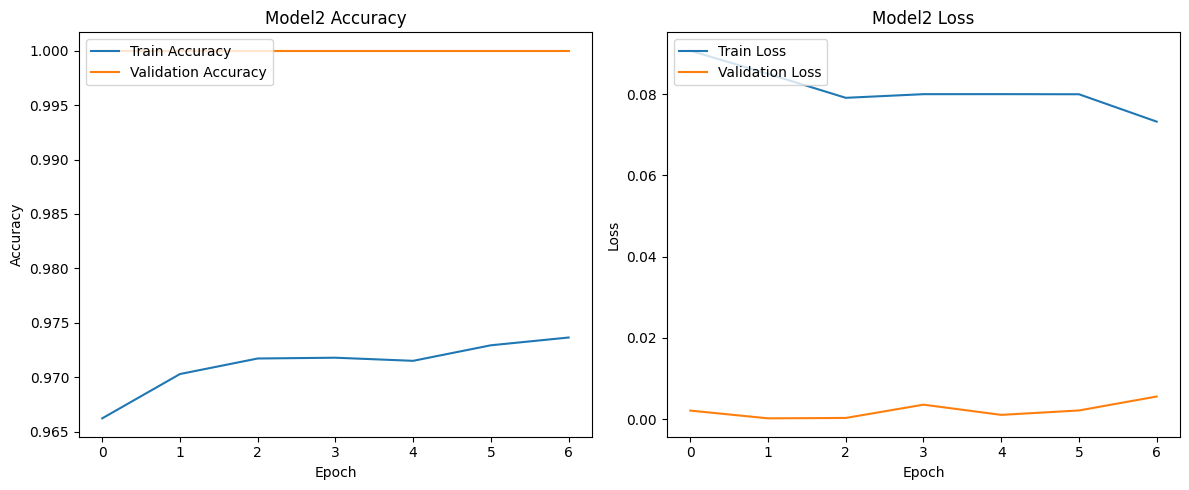

In [20]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [21]:
model_simple = load_model('simple-cnn.keras')

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [23]:
print(predicted_classes)
print(len(set(predicted_classes)))

[13 13 13 13 17 17 17 17 27 27 27 27  1  1  1  1  8  8  8  8  5  5  5  5
  7  7  7  7  4  4  4  4 20 20 20 20 12 12 12 12 23 23 23 23 10 10 10 10
 16 16 16 16 24 24 24 24 18 18 18 18  6  6  6  6  0  0  0  0 14 14 14 14
 19 19 19 19 21 21 21 21 25 25 25 25  2  2  2  2 15 15 15 15 11 11 11 11
 22 22 22 22  3  3  3  3 26 26 26 26  9  9  9  9]
28


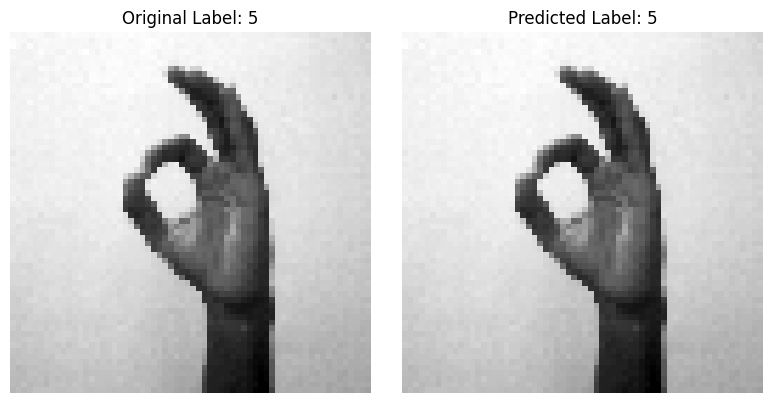

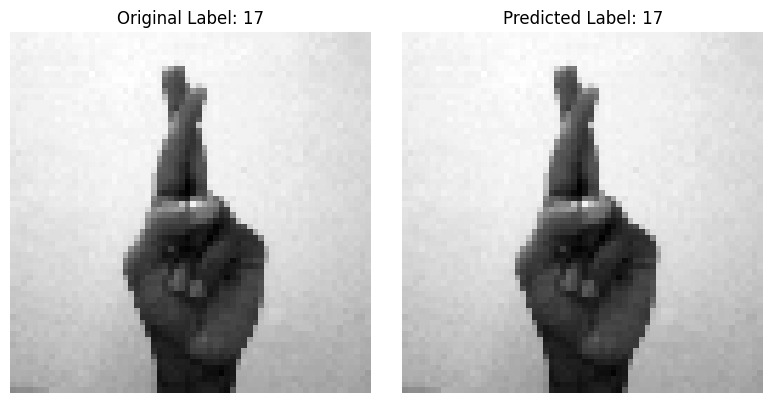

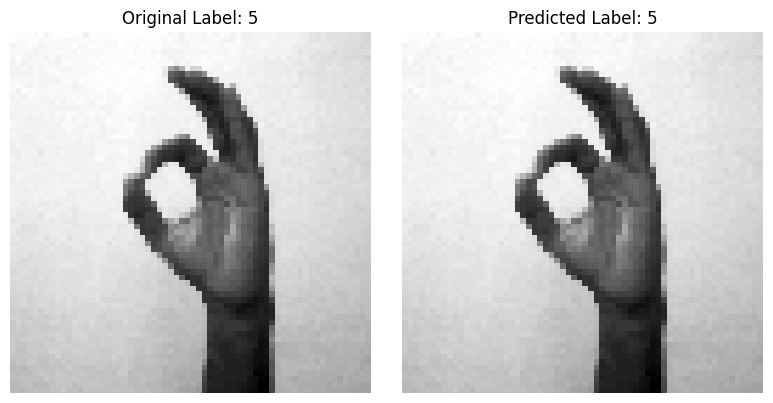

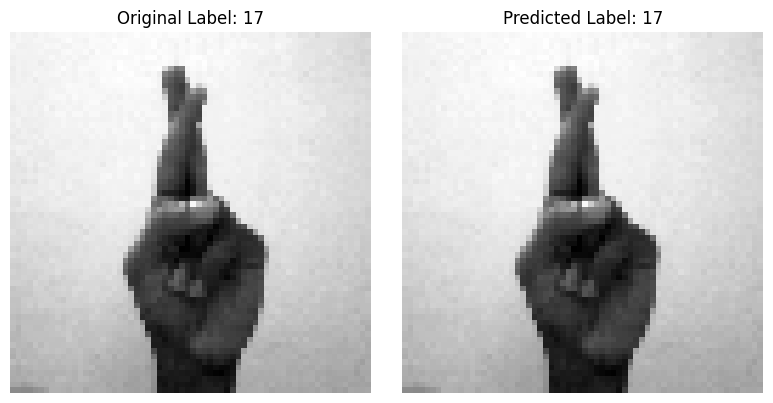

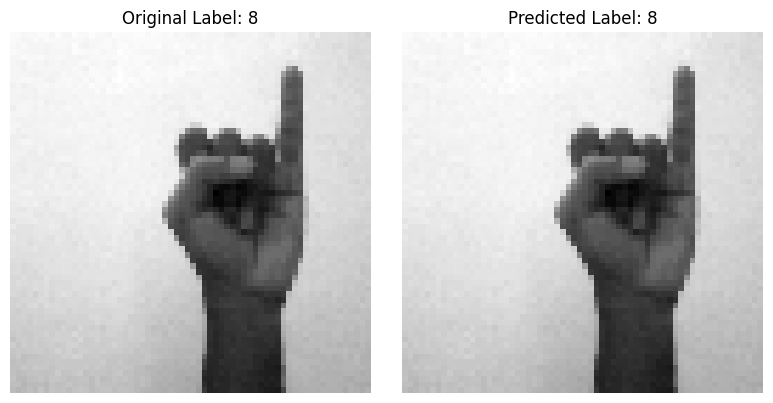

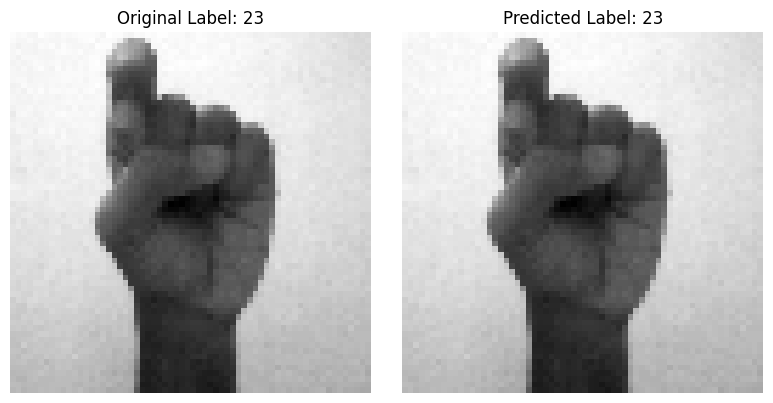

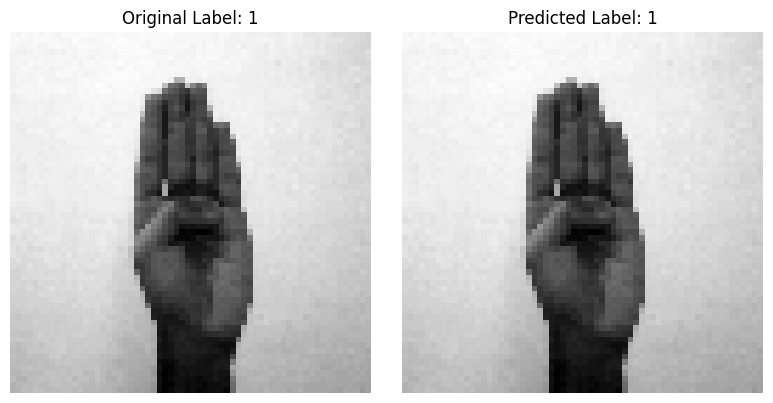

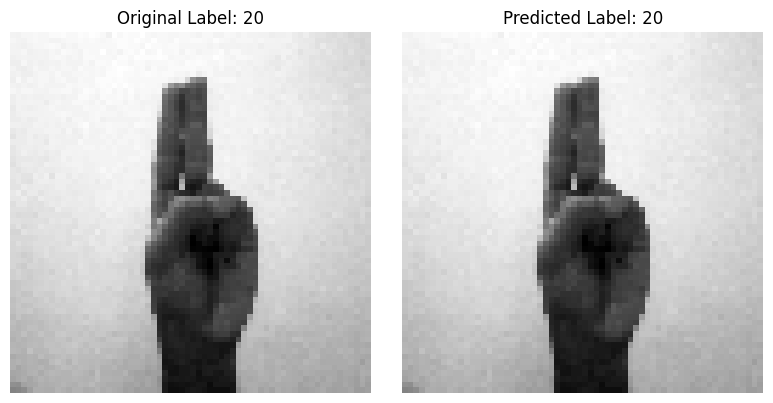

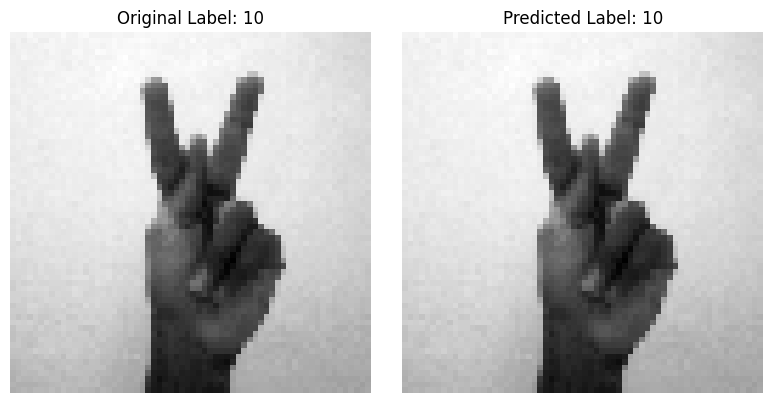

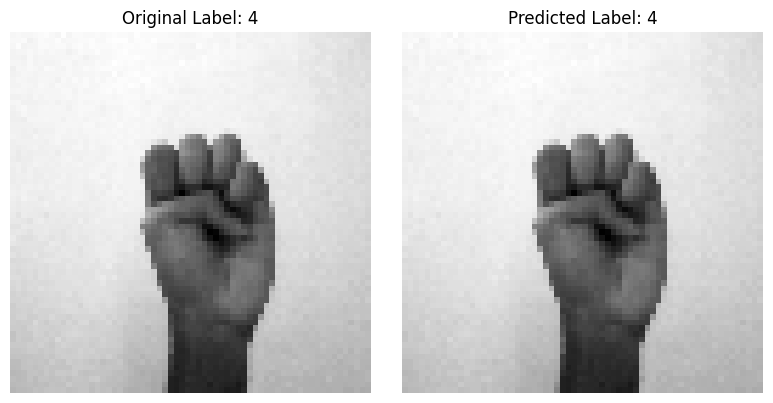

In [24]:
def display_image_with_labels(index):

    original_label = np.argmax(test_labels[index])
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(test_data[index], cmap='gray')
    axes[0].set_title(f"Original Label: {original_label}")
    axes[0].axis('off') 
    
  
    axes[1].imshow(test_data[index].reshape(64, 64), cmap='gray')
    axes[1].set_title(f"Predicted Label: {predicted_classes[index]}")
    axes[1].axis('off')  # Hide the axes
    
    plt.tight_layout()
    plt.show()

for i in np.random.randint(1, 50, 10):
    display_image_with_labels(i)

In [25]:
def load_data2(folder_path, img_size=64):
    data = []
    labels = []
    folders = os.listdir(folder_path)
    
    for label in tqdm(folders, desc="Loading data", unit="class"):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            image_names = os.listdir(label_path)
            sampled_images = random.sample(image_names,len(image_names))
            
            for img_name in sampled_images:
                img_path = os.path.join(label_path, img_name)
                # Load image in grayscale mode
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Resize the image to the target size
                    img_resized = cv2.resize(img, (img_size, img_size))
                    data.append(img_resized)
                    # Convert label to numeric: 'A'=0, ..., 'Z'=25, 'Nothing'=26, 'Space'=27
                    if label == "Nothing":
                        labels.append(26)
                    elif label == "Space":
                        labels.append(27)
                    else:
                        labels.append(ord(label) - ord('A'))

    data = np.array(data)
    labels = np.array(labels)
    
    # Max abs scaling
    data = data.astype('float32') / 255.0
    
    # Reshape data
    data = data.reshape(-1, img_size, img_size, 1)  # (num_samples, height, width, channels)
    
    return data, labels

# **MODEL 3**

In [26]:
train_data2, train_labels2 = load_data2('/kaggle/input/american-sign-language/ASL_Dataset/Train')
test_data2, test_labels2 = load_data2('/kaggle/input/american-sign-language/ASL_Dataset/Test')

train_labels2 = to_categorical(train_labels2, num_classes=28)
test_labels2 = to_categorical(test_labels2, num_classes=28)

Loading data: 100%|██████████| 28/28 [00:00<00:00, 76.35class/s]


In [27]:
checkpoint = ModelCheckpoint(
    'simple-cnn2.keras',  # Name of the file to save the model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # We want to minimize the validation loss
    verbose=1  # Print messages when saving
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    mode='min',  # Stop when the quantity monitored has stopped decreasing
    verbose=1  # Print messages when stopping
)


In [28]:
history = model2.fit(train_data2, train_labels2, 
                    validation_data=(test_data2, test_labels2), 
                    epochs=20,callbacks=[checkpoint, early_stopping] , 
                    batch_size=64)

Epoch 1/20
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9656 - loss: 0.1008
Epoch 1: val_loss improved from inf to 0.00007, saving model to simple-cnn2.keras
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 412s 159ms/step - accuracy: 0.9656 - loss: 0.1008 - val_accuracy: 1.0000 - val_loss: 7.3347e-05
Epoch 2/20
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9807 - loss: 0.0559
Epoch 2: val_loss improved from 0.00007 to 0.00006, saving model to simple-cnn2.keras
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 419s 162ms/step - accuracy: 0.9807 - loss: 0.0559 - val_accuracy: 1.0000 - val_loss: 5.9917e-05
Epoch 3/20
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9847 - loss: 0.0438
Epoch 3: val_loss improved from 0.00006 to 0.00002, saving model to simple-cnn2.keras
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 419s 162ms/step - accuracy: 0.9847 - loss: 0.0438 - val_accuracy: 1.0000 - val_loss: 2.1112e-05
Epoch 4/20
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9883 - loss: 0.0328
Epoch

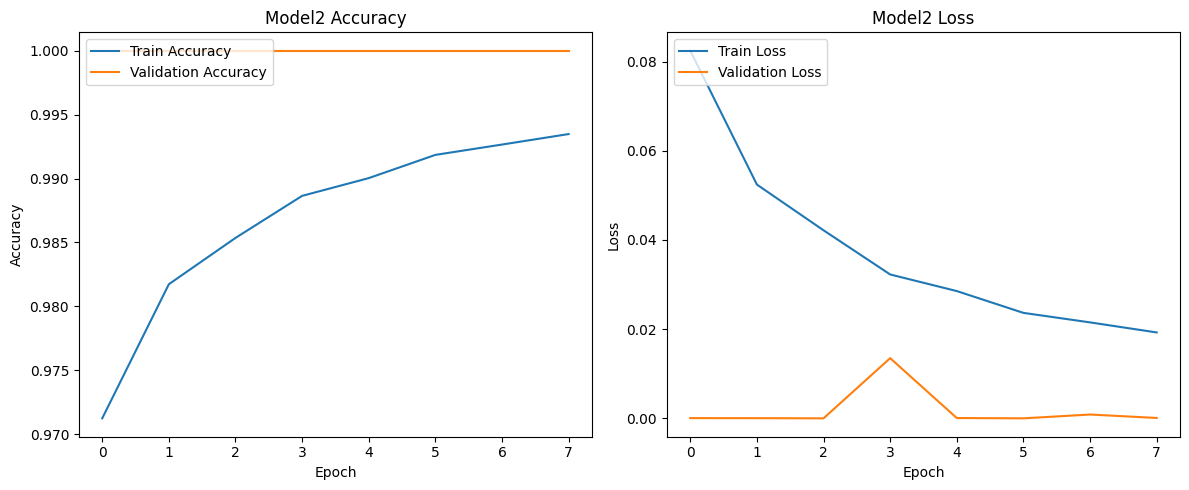

In [29]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [30]:
model_simple2 = load_model('simple-cnn2.keras')

predictions = model.predict(test_data)
predicted_classes2 = np.argmax(predictions, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [31]:
print(predicted_classes)
print(len(set(predicted_classes)))

[13 13 13 13 17 17 17 17 27 27 27 27  1  1  1  1  8  8  8  8  5  5  5  5
  7  7  7  7  4  4  4  4 20 20 20 20 12 12 12 12 23 23 23 23 10 10 10 10
 16 16 16 16 24 24 24 24 18 18 18 18  6  6  6  6  0  0  0  0 14 14 14 14
 19 19 19 19 21 21 21 21 25 25 25 25  2  2  2  2 15 15 15 15 11 11 11 11
 22 22 22 22  3  3  3  3 26 26 26 26  9  9  9  9]
28


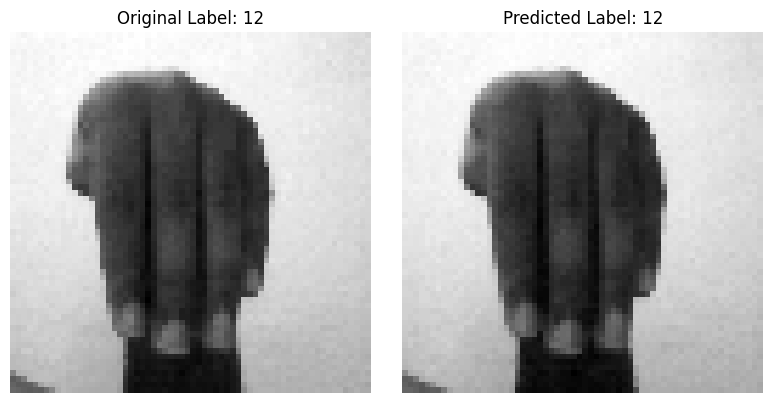

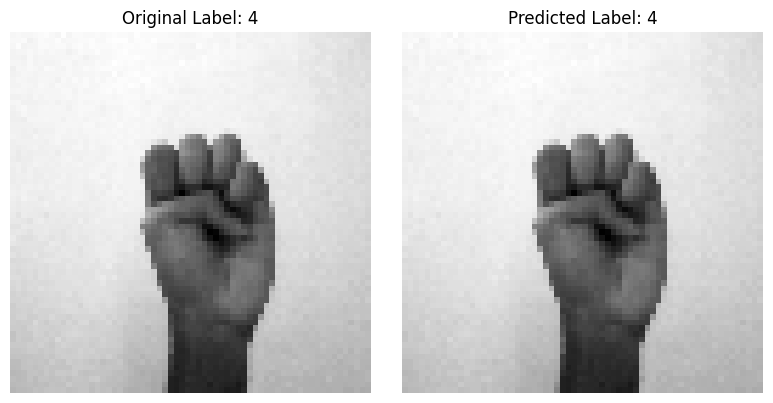

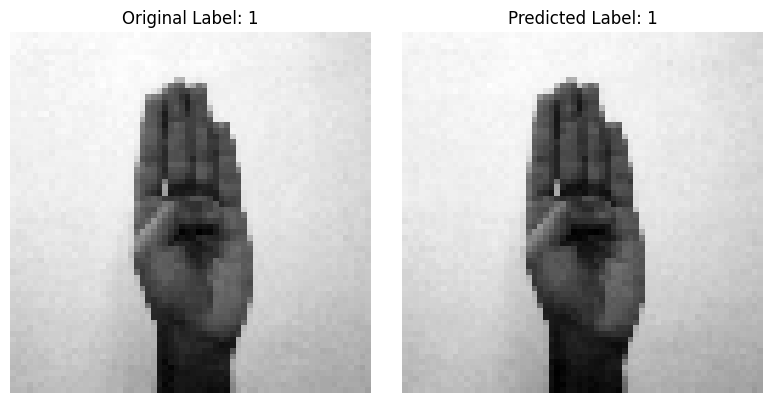

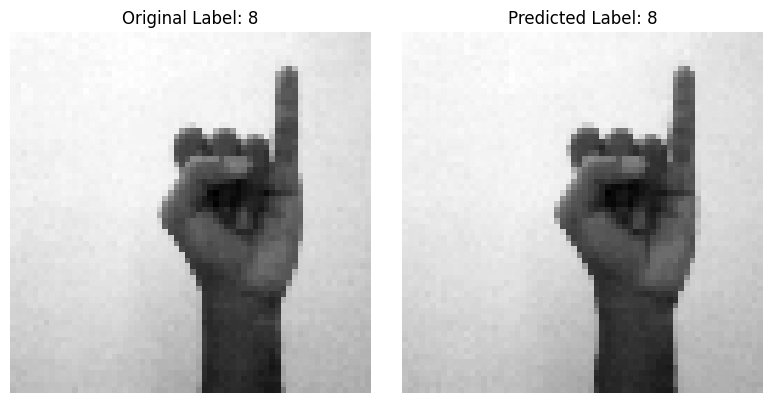

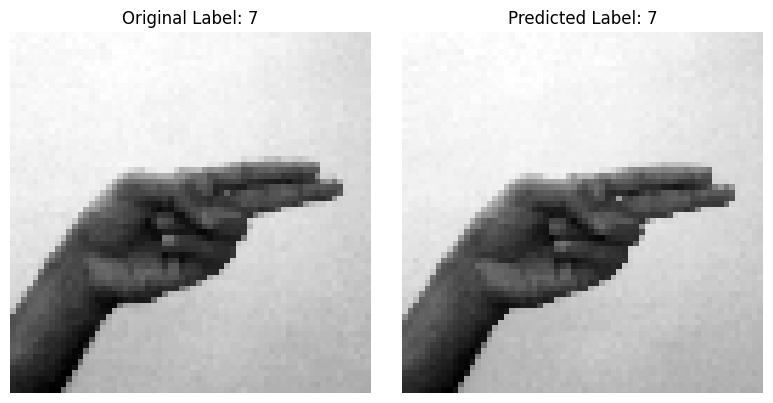

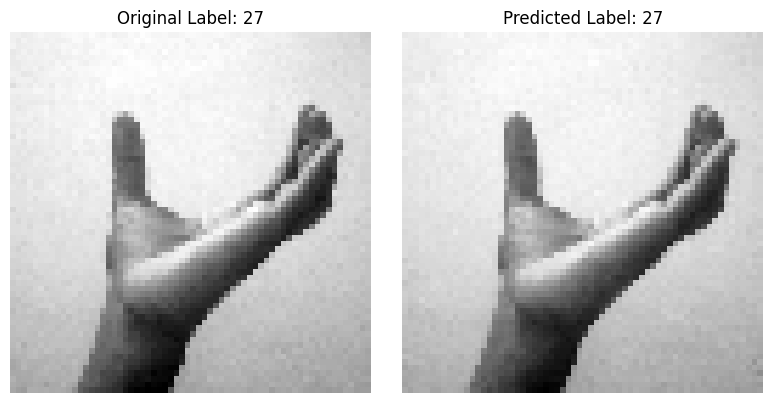

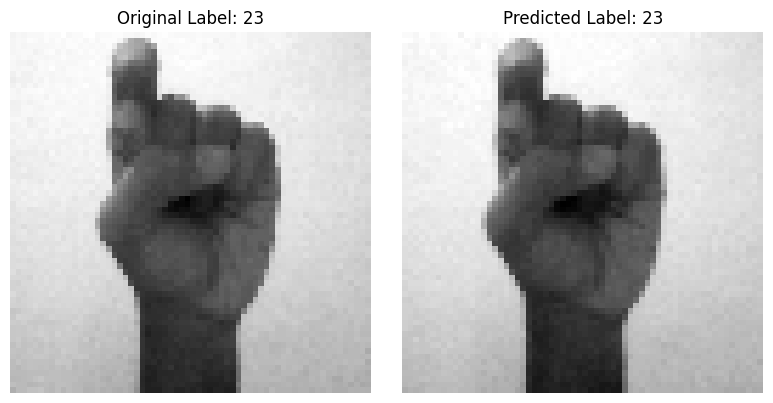

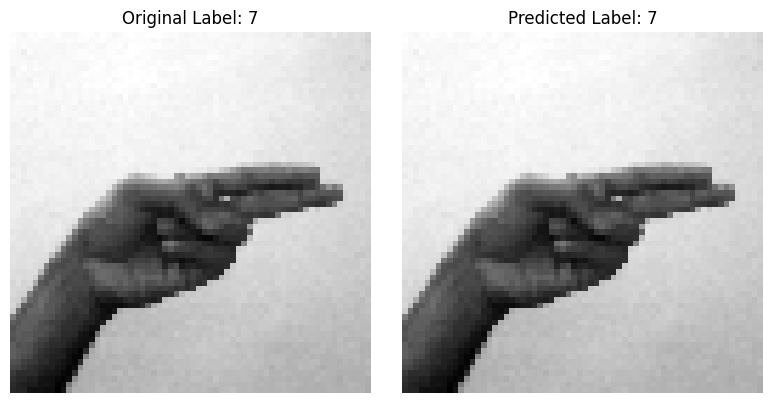

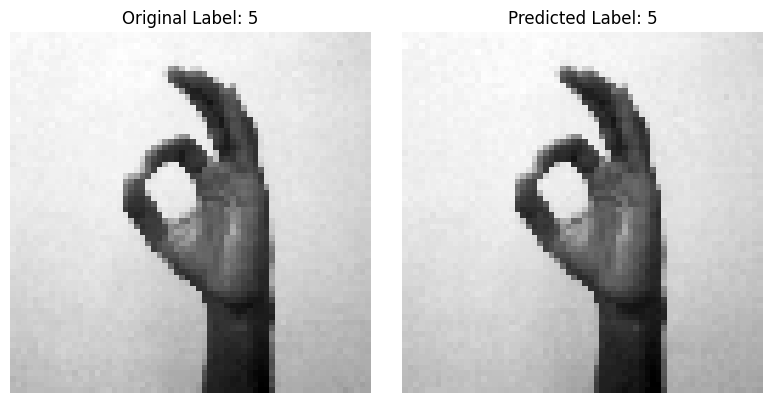

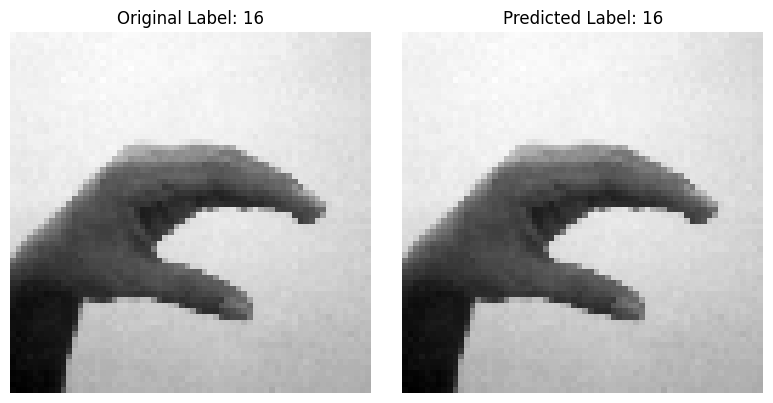

In [32]:
def display_image_with_labels(index):

    original_label = np.argmax(test_labels2[index])
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(test_data2[index], cmap='gray')
    axes[0].set_title(f"Original Label: {original_label}")
    axes[0].axis('off') 
    
  
    axes[1].imshow(test_data[index].reshape(64, 64), cmap='gray')
    axes[1].set_title(f"Predicted Label: {predicted_classes2[index]}")
    axes[1].axis('off')  # Hide the axes
    
    plt.tight_layout()
    plt.show()

for i in np.random.randint(1, 50, 10):
    display_image_with_labels(i)